In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL.Image as Image
import torchvision.models as models
import zipfile

In [2]:
# with zipfile.ZipFile('chest_xray.zip','r') as zip_ref:
#     zip_ref.extractall('./data/')
    
data_path = './data/chest_xray/'

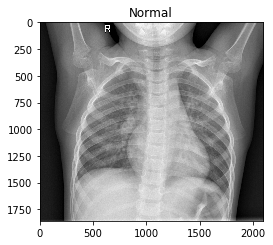

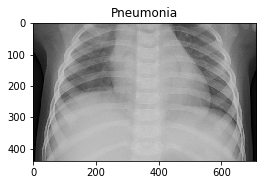

In [3]:
# The function to show an image
def imshow(img, title=None):
    plt.figure(figsize = (4, 4))
    plt.title(title)
    plt.imshow(img)
    plt.pause(0.001)

# Show an image of normal chest.
image_nor = Image.open(data_path + 'train/NORMAL/IM-0115-0001.jpeg')
imshow(image_nor, title = 'Normal')

# Show an image of a pneumonia.
image_pneu = Image.open(data_path + 'train/PNEUMONIA/person1_bacteria_1.jpeg')
imshow(image_pneu, title = 'Pneumonia')

In [4]:
#Prepare for dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
batch_size = 4

transform = transforms.Compose([transforms.Resize(256), transforms.RandomResizedCrop(227), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

trainset = torchvision.datasets.ImageFolder(root=data_path+'train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)

valset = torchvision.datasets.ImageFolder(root=data_path+'val', transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size = 1, shuffle = True)

testset = torchvision.datasets.ImageFolder(root=data_path+'test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)

classes = trainset.classes
print(classes)

['NORMAL', 'PNEUMONIA']


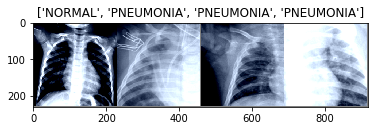

In [5]:
# The function to show a tensor image.    
def imshow_tensor(img, title = None):
    # Set a three channels image.
    img = img.numpy().transpose((1, 2, 0))   
    
    # Unnormalize.
    img = img / 2 + 0.5
    
    # Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
    img = np.clip(img, 0, 1)
    
    # Print label.
    plt.title(title)
    
    plt.imshow(img)
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, label = next(dataiter)
# Show images.
imshow_tensor(torchvision.utils.make_grid(images), title = [classes[label[j]] for j in range(batch_size)])


In [6]:
#choose a device
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

cuda:0
GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [7]:
# trainiter = iter(trainloader)
# features, labels = next(trainiter)
# print(features.shape)
# print(labels.shape)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=2, padding=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32))
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64))
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128))
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256))
        
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256*7*7, 100),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(100, 2),
            nn.LogSigmoid())

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): 

In [9]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

In [10]:
avg_losses = []
epochs = 20
print_freq = 500

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:   499] avg mini-batch loss: 0.485
[epoch: 0, i:   999] avg mini-batch loss: 0.404
[epoch: 1, i:   499] avg mini-batch loss: 0.383
[epoch: 1, i:   999] avg mini-batch loss: 0.366
[epoch: 2, i:   499] avg mini-batch loss: 0.372
[epoch: 2, i:   999] avg mini-batch loss: 0.358
[epoch: 3, i:   499] avg mini-batch loss: 0.342
[epoch: 3, i:   999] avg mini-batch loss: 0.334
[epoch: 4, i:   499] avg mini-batch loss: 0.328
[epoch: 4, i:   999] avg mini-batch loss: 0.324
[epoch: 5, i:   499] avg mini-batch loss: 0.324
[epoch: 5, i:   999] avg mini-batch loss: 0.318
[epoch: 6, i:   499] avg mini-batch loss: 0.302
[epoch: 6, i:   999] avg mini-batch loss: 0.282
[epoch: 7, i:   499] avg mini-batch loss: 0.296
[epoch: 7, i:   999] avg mini-batch loss: 0.305
[epoch: 8, i:   499] avg mini-batch loss: 0.293
[epoch: 8, i:   999] avg mini-batch loss: 0.317
[epoch: 9, i:   499] avg mini-batch loss: 0.265
[epoch: 9, i:   999] avg mini-batch loss: 0.304
[epoch: 10, i:   499] avg mini-batch los

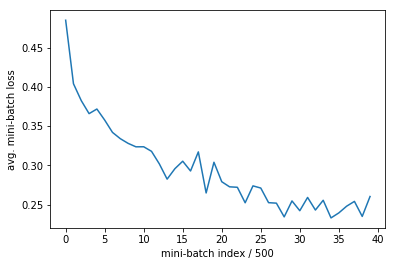

In [11]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

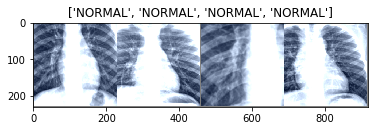

Predicted:  NORMAL NORMAL PNEUMONIA NORMAL


In [12]:
# Check several images.
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow_tensor(torchvision.utils.make_grid(images), title = [classes[labels[j]] for j in range(batch_size)])
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

In [13]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 78 %


In [14]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of NORMAL : 52 %
Accuracy of PNEUMONIA : 94 %
